<font size='6'><b>Quadratic bias calculation from flat lightcone</b></font>


# Init

In [1]:
import sys, os, h5py, bz2, pylab as plt, importlib, itertools, healpy as hp, warnings, seaborn
from tqdm.auto import tqdm, trange
from collections import OrderedDict
from ipywidgets import interactive, fixed
plt.style.use('dark_background')
# plt.style.use('default')
%pylab inline
%load_ext autoreload
%autoreload 2
if 'notebooks' in os.getcwd(): os.chdir('..')
print(os.getcwd())
import matplotlib as mpl
mpl.rcParams.update({"axes.grid" : True})
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.turbo(np.linspace(0,1,8)))


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/tomaszk/miniforge3/envs/ccl250626/lib/python3.13/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['interactive', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


/Users/tomaszk/Archive/projects/220708_cosmogrid_paper/022_quadbias_limber2


# Intro

We will be working with quantity $m=\frac{\rho}{\bar{\rho}}$

# Create cube 


In [2]:
def downsample_3d(arr, M):
    """
    Downsample a 3D array by summing voxels.
    
    Parameters:
    -----------
    arr : ndarray
        Input 3D array with dimensions (N,N,N)
    M : int
        Output dimension (M,M,M)
        
    Returns:
    --------
    ndarray
        Downsampled array with dimensions (M,M,M)
    """
    N = arr.shape[0]
    if N % M != 0:
        raise ValueError(f"Input dimension {N} must be divisible by output dimension {M}")
        
    # Calculate size of blocks to sum over
    block_size = N // M
    
    # Reshape and sum over blocks
    return arr.reshape(M, block_size, M, block_size, M, block_size).mean(axis=(1,3,5))


In [3]:
def downsample_3d_last(arr, M):
    """
    Downsample a 3D array by summing voxels along the last dimension only.
    
    Parameters:
    -----------
    arr : ndarray
        Input 3D array with dimensions (N1,N2,N3)
    M : int
        Output dimension for last axis (N1,N2,M)
        
    Returns:
    --------
    ndarray
        Downsampled array with dimensions (N1,N2,M)
    """
    N = arr.shape[2]  # Size of last dimension
    if N % M != 0:
        raise ValueError(f"Last dimension size {N} must be divisible by output dimension {M}")
        
    # Calculate size of blocks to average over
    block_size = N // M
    
    # Reshape and mean over blocks in last dimension only
    reshaped = arr.reshape(arr.shape[0], arr.shape[1], M, block_size)
    return reshaped.mean(axis=3)


In [4]:
def smooth_3d(arr, sigma):
    """
    Smooth a 3D array using a Gaussian filter.
    
    Parameters:
    -----------
    arr : ndarray
        Input 3D array
    sigma : float
        Standard deviation of Gaussian kernel
        
    Returns:
    --------
    ndarray
        Smoothed array with same dimensions as input
    """
    from scipy.ndimage import gaussian_filter
    return gaussian_filter(arr, sigma=sigma)

In [104]:
def plot_slices(m):

    # Plot slices through the smoothed field
    fig, axes = plt.subplots(1, 4, figsize=(20, 20/4))
    axes = axes.ravel()

    # Select 4 evenly spaced slices
    slice_indices = np.linspace(0, m.shape[2]-1, 4, dtype=int)

    for i, slice_idx in enumerate(slice_indices):
        im = axes[i].imshow(m[:,:,slice_idx], cmap='plasma')
        axes[i].set_title(f'Slice {slice_idx}')
        plt.colorbar(im, ax=axes[i])

    plt.tight_layout()
    plt.show()


In [105]:
def plot_lin_quad(m3D, tag='', fig=None, color='red', lims_lin=[-1, 1], lims_quad=[0, 100], lims_linsq=[-1, 1], lims_3D=[-1, 1]):

    m2D_lin = m3D.mean(axis=2)
    m2D_quad = (m3D**2).mean(axis=2)    
    m2D_linsq = m2D_lin**2


    # Plot histograms of linear and quadratic projections
    n_cols = 4
    if fig is None:
        fig = plt.figure(figsize=(n_cols*5, 4))
        ax = fig.subplots(1, n_cols).ravel()
    else:
        ax = fig.axes


    bins_lin = np.linspace(lims_lin[0], lims_lin[1], 101)
    bins_lin_centers = (bins_lin[1:] + bins_lin[:-1]) / 2
    bins_quad = np.linspace(lims_quad[0], lims_quad[1], 101)
    bins_quad_centers = (bins_quad[1:] + bins_quad[:-1]) / 2
    bins_linsq = np.linspace(lims_linsq[0], lims_linsq[1], 101)
    bins_linsq_centers = (bins_linsq[1:] + bins_linsq[:-1]) / 2
    bins_3D = np.linspace(lims_3D[0], lims_3D[1], 101)
    bins_3D_centers = (bins_3D[1:] + bins_3D[:-1]) / 2

    h_3D = np.histogram(m3D.flatten(), bins=bins_3D, density=True)[0]
    h_lin = np.histogram(m2D_lin.flatten(), bins=bins_lin, density=True)[0]
    h_quad = np.histogram(m2D_quad.flatten(), bins=bins_quad, density=True)[0]
    h_linsq = np.histogram(m2D_linsq.flatten(), bins=bins_linsq, density=True)[0]

    loc = 'upper left'

    ax[0].plot(bins_3D_centers, h_3D, color=color, label=tag, marker='.')
    ax[0].set_title(f'3D histogram')
    ax[0].set_xlabel('m3D')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlim(lims_3D)
    ax[0].legend(loc=loc, frameon=False)

    ax[1].plot(bins_lin_centers, h_lin, color=color, label=tag, marker='.')
    ax[1].set_title(f'Linear projection')
    ax[1].set_xlabel('m2D_lin')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlim(lims_lin)
    ax[1].legend(loc=loc, frameon=False)

    ax[2].plot(bins_quad_centers, h_quad, color=color, label=tag, marker='.')
    ax[2].set_title(f'Quadratic projection') 
    ax[2].set_xlabel('m2D_quad')
    ax[2].set_ylabel('Frequency')
    ax[2].set_xlim(lims_quad)
    ax[2].legend(loc=loc, frameon=False)

    ax[3].plot(bins_linsq_centers, h_linsq, color=color, label=tag, marker='.')
    ax[3].set_title(f'Linear-squared projection')
    ax[3].set_xlabel('m2D_linsq')
    ax[3].set_ylabel('Frequency')
    ax[3].set_xlim(lims_linsq)
    ax[3].legend(loc=loc, frameon=False)

    fig.tight_layout()
    fig.show()

    return fig



In [143]:
def get_cube(N=200, M=100, σ=2.0):
    """Generate a 3D density field with non-Gaussian random fluctuations.
    
    Creates a 3D field by drawing from a normal distribution, smoothing with a 
    Gaussian kernel, normalizing to have mean=1, and optionally downsampling along the last axis.
    
    Args:
        N (int, optional): Size of initial grid. Defaults to 200.
        M (int, optional): Size to downsample the last axis to. Defaults to 100. 
        σ (float, optional): Standard deviation for Gaussian smoothing. Defaults to 2.0.
        
    Returns:
        tuple: (downsampled_field, smoothed_field)
            - downsampled_field: M x M x M array, downsampled density field
            - smoothed_field: N x N x N array, smoothed density field before downsampling
    """

    np.random.seed(42)
    m3D = np.random.normal(scale=1e5/np.sqrt(N**3), size=(N, N, N)) # random noise
    m3D_smooth = smooth_3d(m3D, sigma=σ) # Smooth EPT characteristic scale
    m3D_smooth = m3D_smooth**2 # add non-Gaussianity
    m3D_smooth -= np.min(m3D_smooth) + 1e-10
    m3D_smooth /= np.mean(m3D_smooth) # ρ/ρ_mean
    m3D_downsampled = downsample_3d_last(m3D_smooth, M=M) # emulate thick shells

    print(m3D_downsampled.shape)    
    return m3D_downsampled, m3D_smooth

# Make some field

In [107]:
N = 500 # 1000 Mpc/h
M1 = 20 # 40 Mpc/h
M2 = N//2
σ = 4 # 8 Mpc fluctuations

m3D_lores_1, m3D_hires_1 = get_cube(N=N, M=M1, σ=σ)
m3D_lores_2, m3D_hires_2 = get_cube(N=N, M=M2, σ=σ)

(500, 500, 20)
(500, 500, 250)


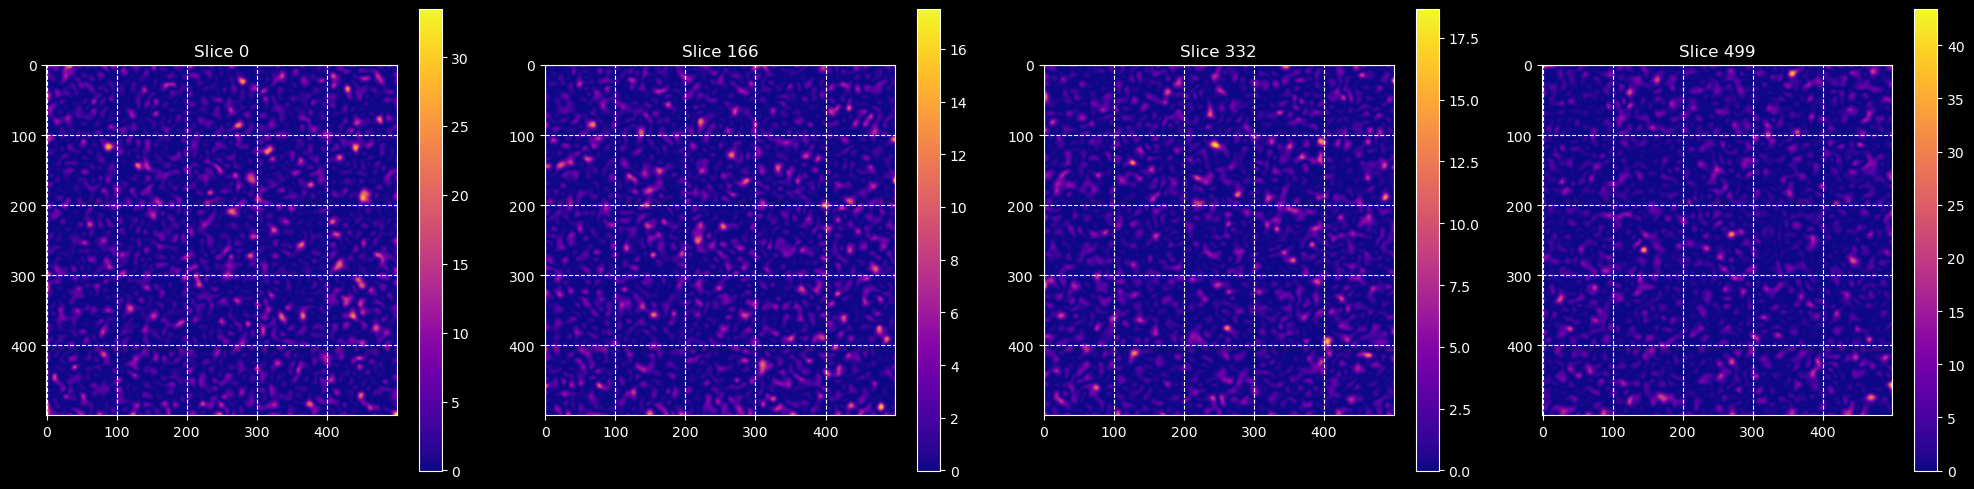

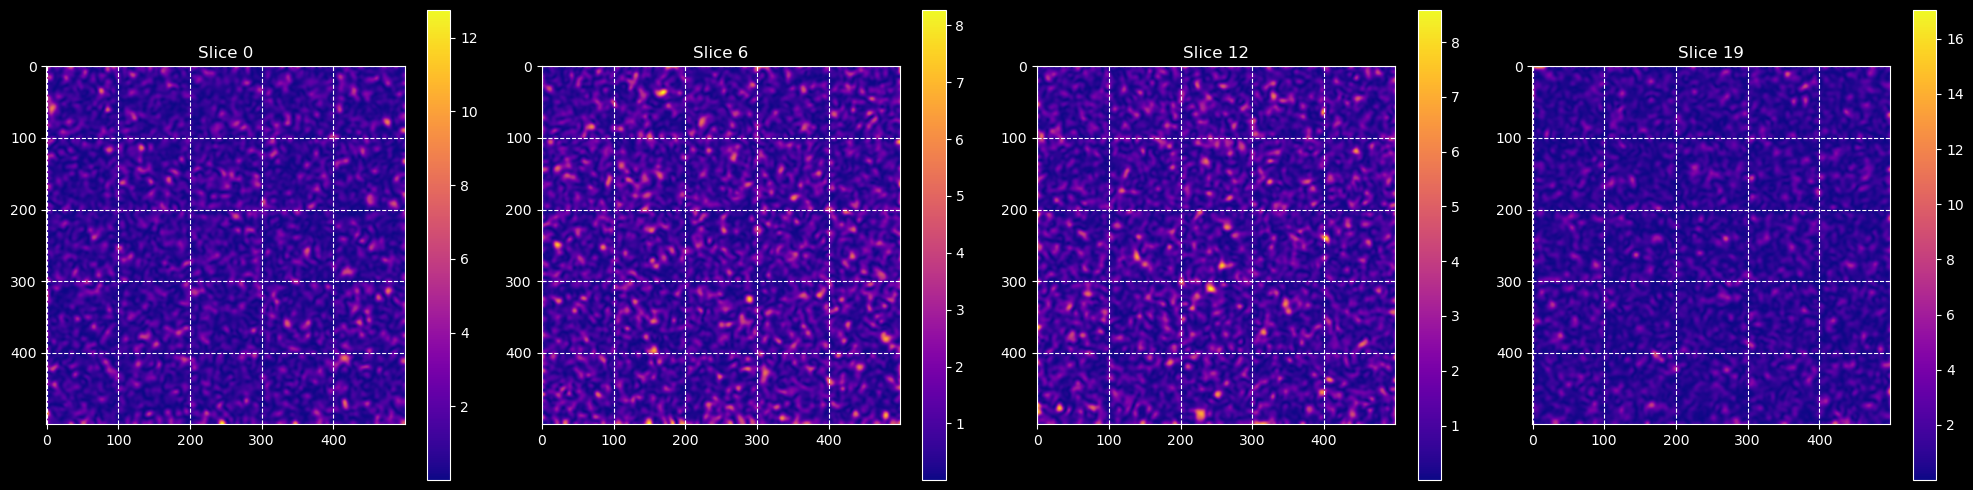

In [108]:
plot_slices(m3D_hires_1)
plot_slices(m3D_lores_1)

# Plot line of sight

In [109]:
def plot_slice(δ3D, i=50, j=50, title=None):
    """Plot values along the third dimension for given i,j indices"""
    plt.figure(figsize=(10, 4))
    plt.plot(δ3D[i,j,:], marker='.', color='lime')
    plt.xlabel('k index')
    plt.ylabel('m3D value along line of sight')
    if title:
        plt.title(title)
    else:
        plt.title(f'Values along k axis at i={i}, j={j}')
    plt.grid(True)
    plt.show()

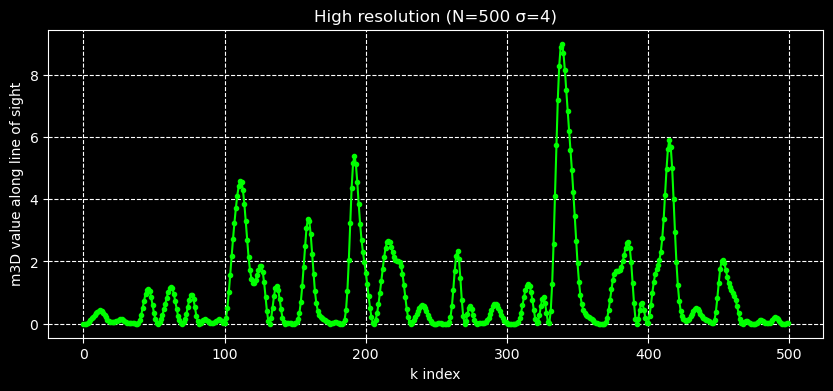

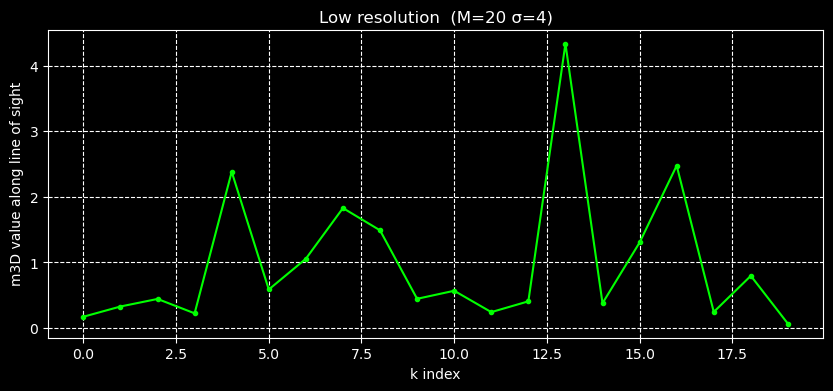

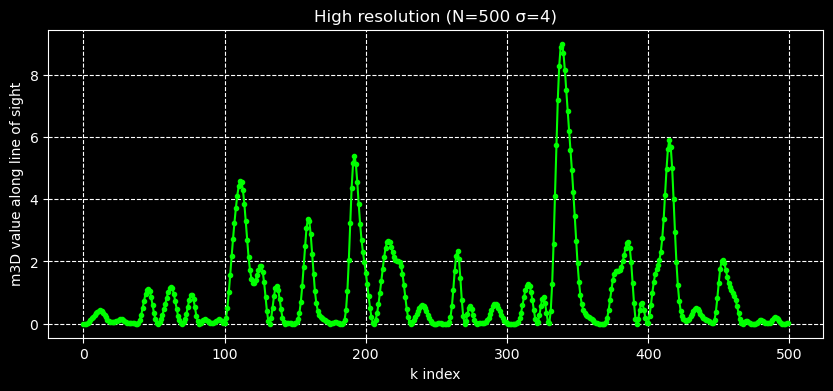

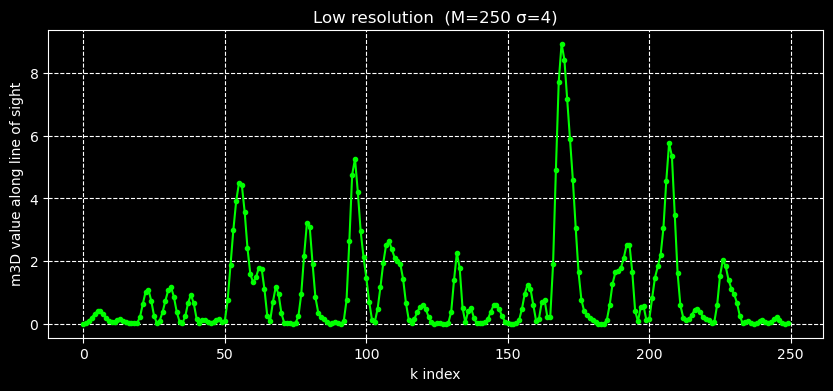

In [110]:

# Plot slices for both high and low resolution cubes
plot_slice(m3D_hires_1, title=f'High resolution (N={N} σ={σ})')
plot_slice(m3D_lores_1, title=f'Low resolution  (M={M1} σ={σ})')
plot_slice(m3D_hires_2, title=f'High resolution (N={N} σ={σ})') 
plot_slice(m3D_lores_2, title=f'Low resolution  (M={M2} σ={σ})')



# Plot linear and quadratic projections of 3D field

/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/3886185277.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


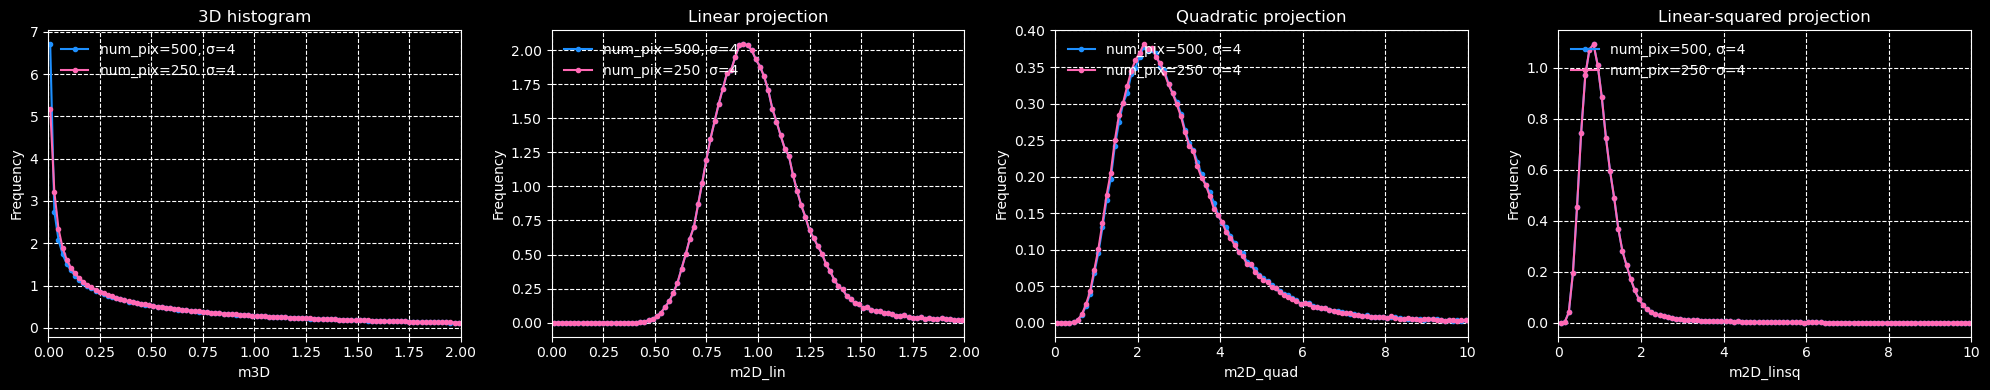

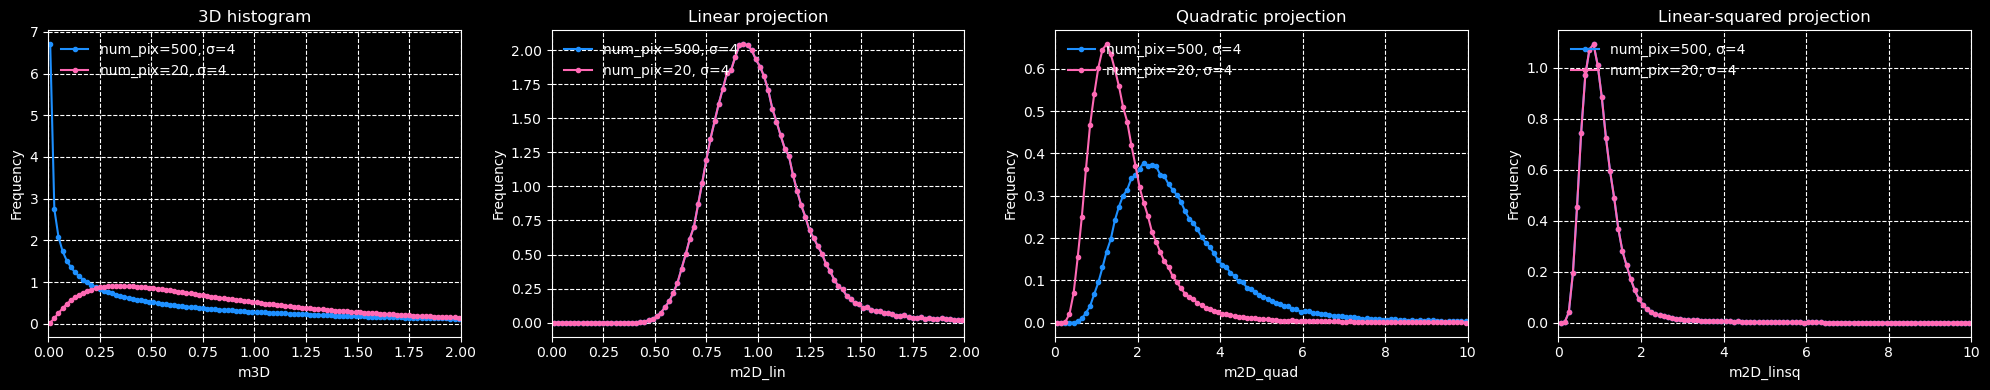

In [111]:
lims_3D = [0, 2]
lims_linsq = [0, 10]
lims_quad = [0, 10]
lims_lin = [0, 2]

fig = plot_lin_quad(m3D_hires_2, tag=f'num_pix={N}, σ={σ}', color='dodgerblue', lims_lin=lims_lin, lims_quad=lims_quad, lims_linsq=lims_linsq, lims_3D=lims_3D)
fig = plot_lin_quad(m3D_lores_2, tag=f'num_pix={M2}  σ={σ}', color='hotpink', lims_lin=lims_lin, lims_quad=lims_quad, lims_linsq=lims_linsq, lims_3D=lims_3D, fig=fig);

fig = plot_lin_quad(m3D_hires_1, tag=f'num_pix={N}, σ={σ}', color='dodgerblue', lims_lin=lims_lin, lims_quad=lims_quad, lims_linsq=lims_linsq, lims_3D=lims_3D)
fig = plot_lin_quad(m3D_lores_1, tag=f'num_pix={M1}, σ={σ}', color='hotpink', lims_lin=lims_lin, lims_quad=lims_quad, lims_linsq=lims_linsq, lims_3D=lims_3D, fig=fig);

$\rightarrow$ Downsampling by a factor of 2 is OK, the quadratic term is correct.

$\rightarrow$ Downsampling by a factor results in wrong quadratic term.

# Quad map approximation from the linear-squared map (Limber-LOS)

In [134]:
def compare_linsq_quad(m_hires, m_lores, lims_quad, tag='', cmap='plasma', vlim=[-1, 1], calibr=False):

    bins_quad = np.linspace(lims_quad[0], lims_quad[1], 101)
    bins_quad_centers = (bins_quad[1:] + bins_quad[:-1]) / 2

    m2D_lin = m_lores.mean(axis=2)
    m2D_quad = (m_hires**2).mean(axis=2)    
    m2D_linsq = m2D_lin**2
    if calibr == 'fit':
        m2D_linsq = calibrate_linsq(m_lores, m_hires)
    elif calibr == 'cov':
        m2D_linsq = calibrate_cov(m_lores)

    m2D_lin_centered = m2D_lin - m2D_lin.mean()
    m2D_quad_centered = m2D_quad - m2D_quad.mean()
    m2D_linsq_centered = m2D_linsq - m2D_linsq.mean()

    h_quad = np.histogram(m2D_quad_centered.flatten(), bins=bins_quad, density=True)[0]
    h_linsq = np.histogram(m2D_linsq_centered.flatten(), bins=bins_quad, density=True)[0]

    n_cols, n_rows = 4, 2
    loc = 'upper left'
    fig = plt.figure(figsize=(n_cols*5, n_rows*4))
    ax = fig.subplots(n_rows, n_cols)

    fig.colorbar(ax[0,0].pcolormesh(m2D_lin_centered, cmap=cmap, vmin=vlim[0]/2, vmax=vlim[1]/2))
    ax[0,0].set_title('Linear projection')
    fig.colorbar(ax[0,1].pcolormesh(m2D_quad_centered, cmap=cmap, vmin=vlim[0], vmax=vlim[1]))
    ax[0,1].set_title('Quadratic projection')
    fig.colorbar(ax[0,2].pcolormesh(m2D_linsq_centered, cmap=cmap, vmin=vlim[0], vmax=vlim[1]))
    ax[0,2].set_title('Quadratic projection approximation')
    
    diff = m2D_linsq_centered - m2D_quad_centered
    fig.colorbar(ax[0,3].pcolormesh(diff, cmap='RdBu_r', vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 99)))
    ax[0,3].set_title('Difference approximation - quadratic')
    


    ax[1,0].plot(bins_quad_centers, h_quad, color='dodgerblue', label='quad', marker='.')
    ax[1,0].plot(bins_quad_centers, h_linsq, color='lime', label='linsq', marker='.')
    ax[1,0].set_xlabel('map value')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend(loc=loc, frameon=False)

    ax[1,1].plot(bins_quad_centers, h_quad-h_linsq, color='dodgerblue', label=tag, marker='.')
    ax[1,1].set_ylabel('m2D_quad - m2D_quad_approx')
    ax[1,1].set_xlabel('map value')

    bins2d = np.linspace(vlim[0], vlim[1], 100)

    ax[1,2].hist2d(m2D_lin_centered.flatten(), m2D_linsq_centered.flatten(), bins=bins2d, cmap='Spectral_r')
    ax[1,2].set_xlabel('m2D_lin')
    ax[1,2].set_ylabel('m2D_linsq')
    ax[1,2].legend(loc=loc, frameon=False)
    ax[1,2].plot([vlim[0], vlim[1]], [vlim[0], vlim[1]], color='black', linestyle='--')

    ax[1,3].hist2d(m2D_quad_centered.flatten(), m2D_linsq_centered.flatten(), bins=bins2d, cmap='Spectral_r')
    ax[1,3].set_xlabel('m2D_quad')
    ax[1,3].set_ylabel('m2D_quad_approx')
    ax[1,3].legend(loc=loc, frameon=False)
    ax[1,3].plot([vlim[0], vlim[1]], [vlim[0], vlim[1]], color='black', linestyle='--')

    fig.subplots_adjust(wspace=0.3, hspace=0.3)


/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,2].legend(loc=loc, frameon=False)
/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,3].legend(loc=loc, frameon=False)


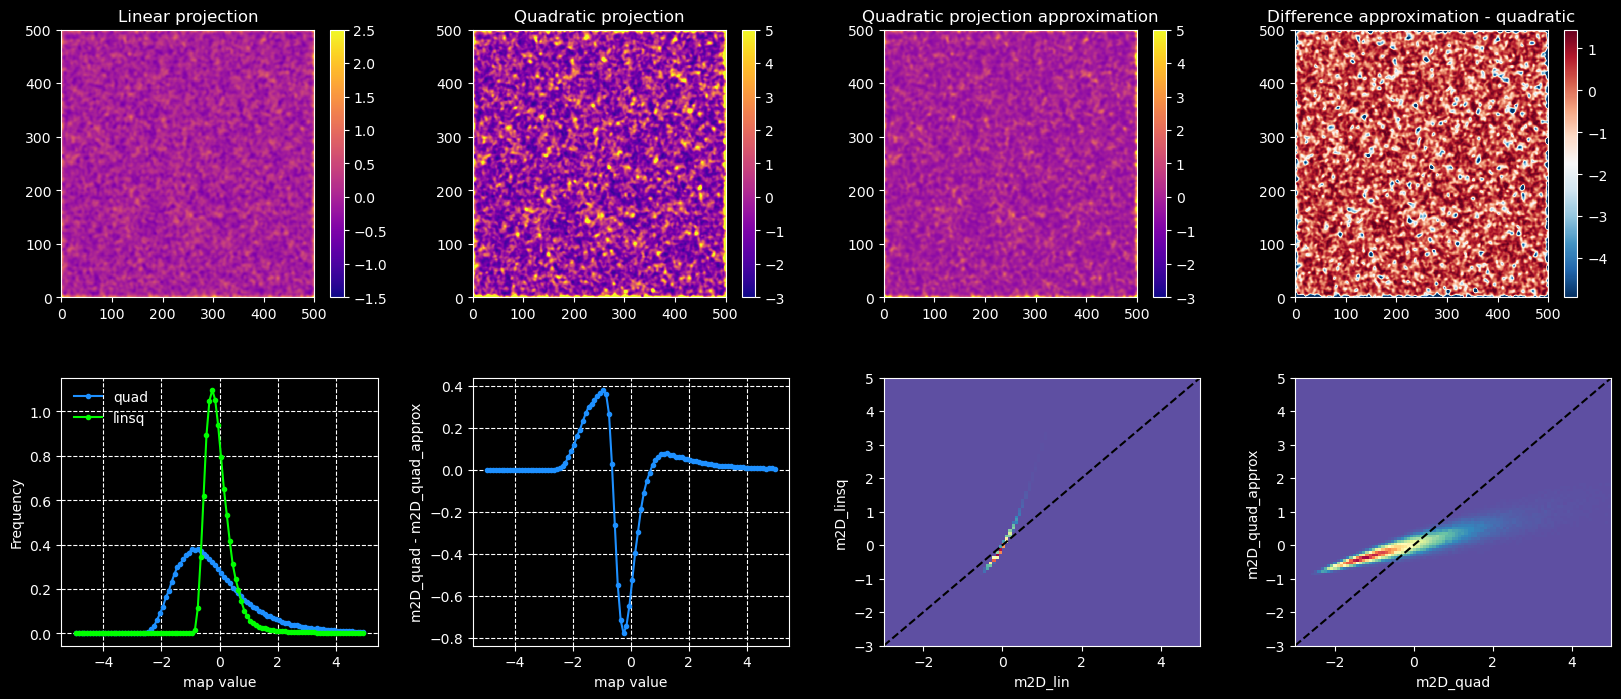

In [135]:
compare_linsq_quad(m3D_hires_1, m3D_lores_1, lims_quad=[-5, 5], tag='', vlim=[-3, 5])

$\rightarrow$ The approximate map is too low, as we expect. Can we fix it?

# What is the best we can do?

Fit a linear model against the quadratic term:

$m_{fit} = a + b*m_{lin} + c*m_{lin}^2$ 

This model is motivated by the Lognormal model, I am working on the math.

Then minimize:

$\|m_{fit} - m_{quad}\|^2$










In [137]:
def calibrate_linsq(m_lores, m_hires, cmap='plasma'):
    
    m2D_lin = m_lores.mean(axis=2)
    m2D_quad = (m_hires**2).mean(axis=2)    
    m2D_linsq = m2D_lin**2

    m2D_lin_centered = m2D_lin - m2D_lin.mean()
    m2D_quad_centered = m2D_quad - m2D_quad.mean()
    m2D_linsq_centered = m2D_linsq - m2D_linsq.mean()


    s_ = np.s_[20:-20, 20:-20]
    X = np.vstack([np.ones_like(m2D_lin_centered[s_].ravel()), m2D_lin_centered[s_].ravel(), m2D_linsq_centered[s_].ravel()]).T
    y = m2D_quad_centered[s_].ravel()
    res = np.linalg.lstsq(X, y, rcond=None)
    a, b, c = res[0]
    print(a, b, c)

    m2D_fit = a + b*m2D_lin_centered + c*m2D_linsq_centered

    return m2D_fit

0.0008280902425927909 -0.022876987590642717 2.918851283767314


/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,2].legend(loc=loc, frameon=False)
/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,3].legend(loc=loc, frameon=False)


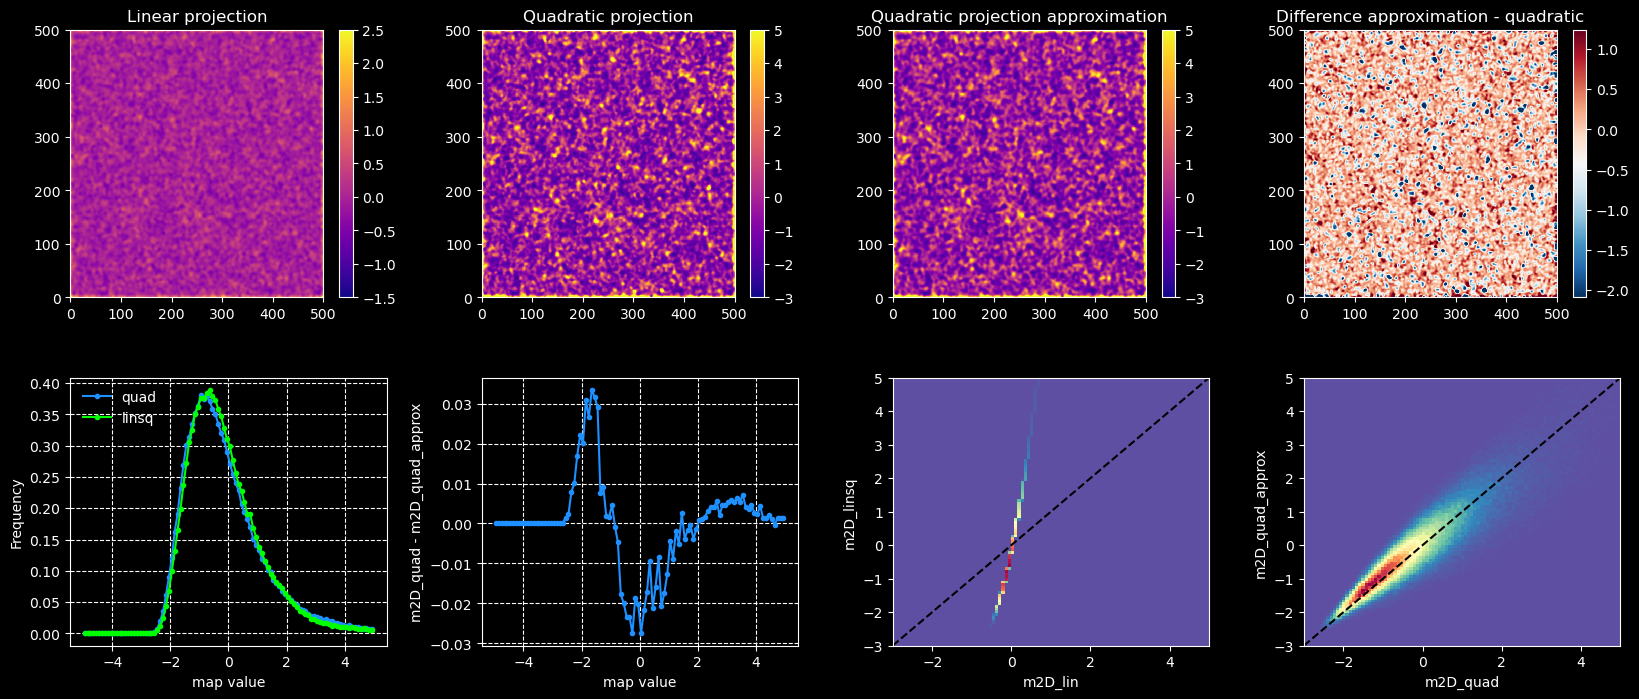

In [138]:
compare_linsq_quad(m3D_hires_1, m3D_lores_1, lims_quad=[-5, 5], tag='', vlim=[-3, 5], calibr='fit')

# How to calibrate the linear-squared using cross correlation with the linear term?

Let's assume we can get the cross-spectrum between the linear and quad terms from the EPT calculator. How to use it to calibrate the approx. quad maps?















In [139]:
def covariance_matching_weight(X, p, c, lam=0.0):
    """
    X : (n, d) design matrix
    p : (n,)   target vector
    c : scalar desired covariance between q = X w and p
    lam : ridge term (0 gives the minimal-norm solution)

    Returns
    -------
    w : (d,) weight vector such that q and p have covariance closest to c
    """
    # ---- 1. centre the data cheaply ----
    Xc = X - X.mean(axis=0, keepdims=True)   # subtract column means
    pc = p - p.mean()                        # subtract target mean

    # ---- 2. compute a = (1/n) Xcᵀ pc  -------------------------------
    n = X.shape[0]
    a = (Xc.T @ pc) / n                      # shape (d,)

    # ---- 3. closed-form weight on direction a -----------------------
    norm2 = a @ a
    if norm2 == 0:
        raise ValueError("Cannot achieve non-zero covariance: X and p are orthogonal.")

    return (c / (norm2 + lam)) * a


In [140]:
def calibrate_cov(m_lores):
    
    m2D_lin = m_lores.mean(axis=2)    
    m2D_linsq = m2D_lin**2
    m2D_lin_centered = m2D_lin - m2D_lin.mean()
    m2D_linsq_centered = m2D_linsq - m2D_linsq.mean()

    
    X = np.vstack([np.ones_like(m2D_lin_centered.ravel()), m2D_lin_centered.ravel(), m2D_linsq_centered.ravel()]).T
    y = m2D_lin_centered.ravel()
    coefs = covariance_matching_weight(X, y, c=xc)
    print(coefs)
    m2D_fit = coefs[0] + coefs[1]*m2D_lin_centered + coefs[2]*m2D_linsq_centered
    print('covariance')
    print(np.cov(m2D_fit.ravel(), m2D_lin_centered.ravel()))
    

    return m2D_fit

Calculate the correlation - this will be given by EPT calculator. For now use the "truth".

In [141]:
m_lores = m3D_lores_1
m_hires = m3D_hires_1

m2D_lin = m_hires.mean(axis=2)
m2D_quad = (m_hires**2).mean(axis=2)    

m2D_lin_centered = m2D_lin - m2D_lin.mean()
m2D_quad_centered = m2D_quad - m2D_quad.mean()

covmat = np.cov(m2D_quad_centered.flatten(), m2D_lin_centered.flatten())
print(covmat)
xc = covmat[0,1]
print(xc)

[[3.40884348 0.40545555]
 [0.40545555 0.05821932]]
0.40545555282267665


[0.         1.03795629 2.48017978]
covariance
[[2.95055947 0.40545717]
 [0.40545717 0.05821932]]


/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,2].legend(loc=loc, frameon=False)
/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_9446/2131724113.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,3].legend(loc=loc, frameon=False)


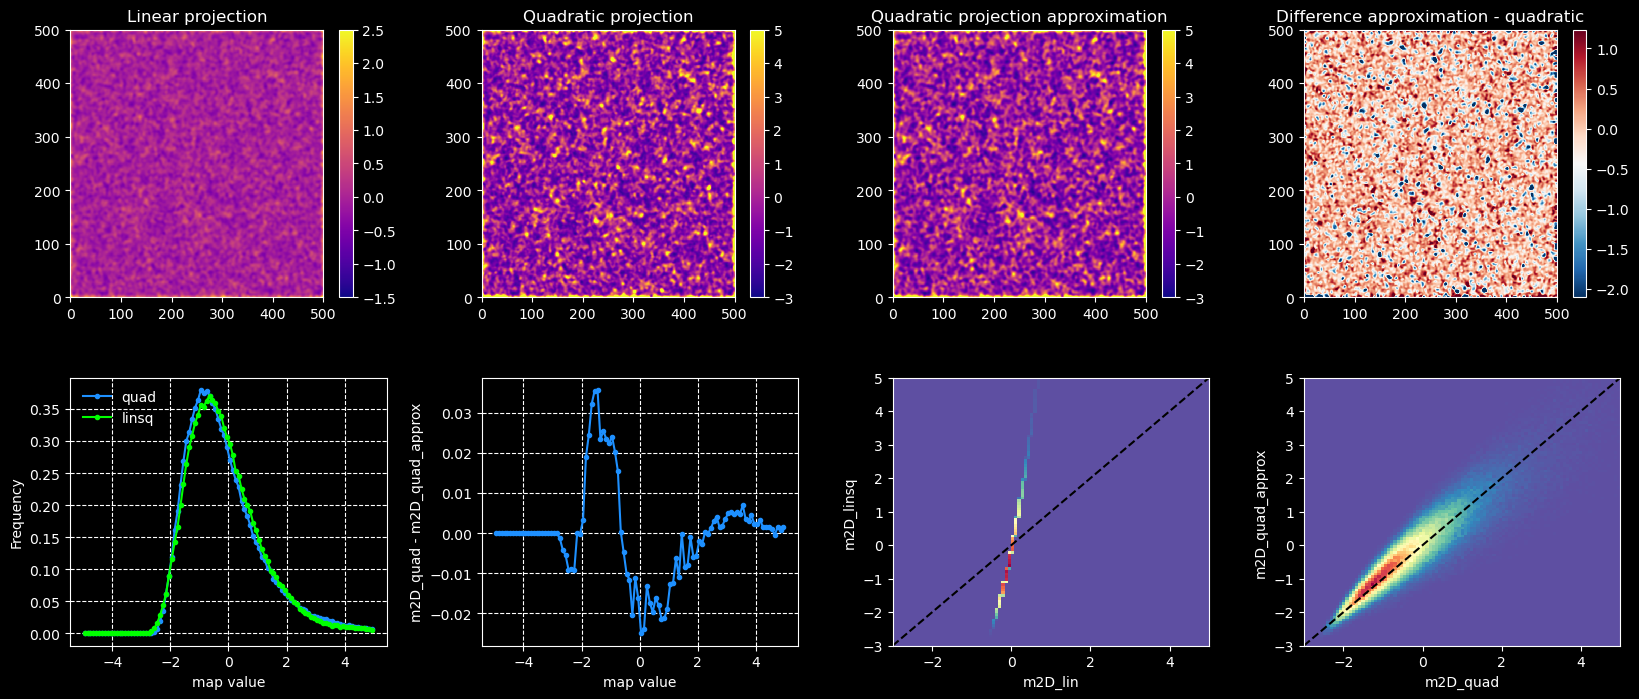

In [142]:
compare_linsq_quad(m3D_hires_1, m3D_lores_1, lims_quad=[-5, 5], tag='', vlim=[-3, 5], calibr='cov')

$\rightarrow$ Variance of the approximate quad is still under-estimated.

$\rightarrow$ Cross-correlation matches well with the truth.

$\rightarrow$ Map histogram matches well.

$\rightarrow$ We can try to implement this in spherical harmonic space.
